In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define the path to the folder
folder_path = Path("C:/Users/crazy/OneDrive - The City College of New York/DSE I2100 - Applied Machine Learning and Data Mining/Project")
csv_file = folder_path.glob("Processed_Data_v2.csv").__next__()

# Load CSV file into DataFrame
data = pd.read_csv(csv_file)

In [3]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057417 entries, 0 to 1057416
Data columns (total 15 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     1057417 non-null  object 
 1   CRASH TIME                     1057417 non-null  object 
 2   LATITUDE                       1057417 non-null  float64
 3   LONGITUDE                      1057417 non-null  float64
 4   CONTRIBUTING FACTOR VEHICLE 1  1057417 non-null  object 
 5   CONTRIBUTING FACTOR VEHICLE 2  1057417 non-null  object 
 6   CONTRIBUTING FACTOR VEHICLE 3  1057417 non-null  object 
 7   CONTRIBUTING FACTOR VEHICLE 4  1057417 non-null  object 
 8   CONTRIBUTING FACTOR VEHICLE 5  1057417 non-null  object 
 9   VEHICLE TYPE CODE 1            1057417 non-null  object 
 10  VEHICLE TYPE CODE 2            1057417 non-null  object 
 11  VEHICLE TYPE CODE 3            1057417 non-null  object 
 12  VEHICLE TYPE C

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

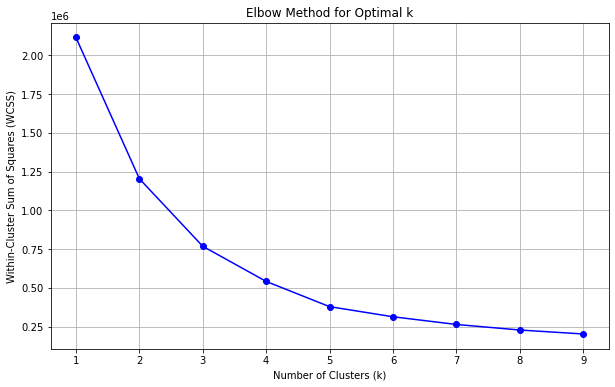

In [4]:
# Extract latitude and longitude columns
X = data[['LATITUDE', 'LONGITUDE']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the range of k values to test
k_values = range(1, 10)

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


elbow starts to become linear around k = 5, which matches amount of boroughs on NYC. Will try k=4 & 6 to check accuracy

In [5]:
# Extract latitude and longitude columns
X = data[['LATITUDE', 'LONGITUDE']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering with the optimal number of clusters (let's say k=5)
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Drop latitude and longitude columns
data.drop(['LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
# Select categorical columns for encoding
cat_cols = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
            'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
            'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
            'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encode categorical variables
encoded_cols = pd.DataFrame(encoder.fit_transform(data[cat_cols]))
encoded_cols.columns = encoder.get_feature_names_out(cat_cols)

# Replace categorical columns with encoded ones
data = pd.concat([data.drop(columns=cat_cols), encoded_cols], axis=1)

In [7]:
# Extract features from 'CRASH DATE' and 'CRASH TIME'
data['CRASH DATE'] = pd.to_datetime(data['CRASH DATE'])
data['CRASH TIME'] = pd.to_datetime(data['CRASH TIME'])

data['year'] = data['CRASH DATE'].dt.year
data['month'] = data['CRASH DATE'].dt.month
data['day'] = data['CRASH DATE'].dt.day
data['day_of_week'] = data['CRASH DATE'].dt.dayofweek

data['hour'] = data['CRASH TIME'].dt.hour
data['minute'] = data['CRASH TIME'].dt.minute
data['second'] = data['CRASH TIME'].dt.second

In [8]:
# Split the dataset into features (X) and target variable (y)
X = data.drop(columns=['CLASS TYPE','CRASH DATE', 'CRASH TIME'])
y = data['CLASS TYPE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057417 entries, 0 to 1057416
Columns: 107 entries, Cluster to second
dtypes: float64(99), int32(1), int64(7)
memory usage: 859.2 MB


In [13]:
# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=2500)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print("Logistic Regression Accuracy:", log_reg_accuracy)

# 2. Decision Trees
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print("Decision Trees Accuracy:", dt_accuracy)

# 3. Random Forests
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forests Accuracy:", rf_accuracy)

# 4. Gradient Boosting Machines
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
gbm_accuracy = accuracy_score(y_test, gbm_pred)
print("Gradient Boosting Machines Accuracy:", gbm_accuracy)

# 5. XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb = XGBClassifier(use_label_encoder=False, n_jobs=-1)
xgb.fit(X_train, y_train_encoded)
xgb_pred = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test_encoded, xgb_pred)
print("XGBoost Accuracy:", xgb_accuracy)

# 6. K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)

# # 5. Support Vector Machines
# svm = SVC()
# svm.fit(X_train, y_train)
# svm_pred = svm.predict(X_test)
# svm_accuracy = accuracy_score(y_test, svm_pred)
# print("Support Vector Machines Accuracy:", svm_accuracy)

# # 6. K-Nearest Neighbors
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)
# knn_pred = knn.predict(X_test)
# knn_accuracy = accuracy_score(y_test, knn_pred)
# print("K-Nearest Neighbors Accuracy:", knn_accuracy)

# # 7. Naive Bayes
# nb = GaussianNB()
# nb.fit(X_train, y_train)
# nb_pred = nb.predict(X_test)
# nb_accuracy = accuracy_score(y_test, nb_pred)
# print("Naive Bayes Accuracy:", nb_accuracy)

# # 8. Neural Networks
# mlp = MLPClassifier()
# mlp.fit(X_train, y_train)
# mlp_pred = mlp.predict(X_test)
# mlp_accuracy = accuracy_score(y_test, mlp_pred)
# print("Neural Networks Accuracy:", mlp_accuracy)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8133286678897694
Decision Trees Accuracy: 0.7213311645325414
Random Forests Accuracy: 0.8195608178396474
Gradient Boosting Machines Accuracy: 0.8231071854135538
XGBoost Accuracy: 0.8253626751905582
K-Nearest Neighbors Accuracy: 0.7672258894289875


In [14]:
# Classification report Logistic Regression
print('Classification report Logistic Regression')
print(classification_report(y_test, log_reg_pred))

# Classification report Decision Trees
print('Classification report Decision Trees')
print(classification_report(y_test, dt_pred))

# Classification report Random Forests
print('Classification report Random Forests')
print(classification_report(y_test, rf_pred))

# Classification report Gradient Boosting Machines
print('Classification report Gradient Boosting Machines')
print(classification_report(y_test, gbm_pred))

# Classification report XGBoost
print('Classification report XGBoost')
print(classification_report(y_test_encoded, xgb_pred))

# Classification report K-Nearest Neighbors
print('Classification report K-Nearest Neighbors')
print(classification_report(y_test, knn_pred))

Classification report Logistic Regression


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Class 0       0.82      0.98      0.89    165012
     Class 1       0.76      0.22      0.34     46095
     Class 2       0.00      0.00      0.00       198
     Class 3       0.00      0.00      0.00       179

    accuracy                           0.81    211484
   macro avg       0.40      0.30      0.31    211484
weighted avg       0.80      0.81      0.77    211484

Classification report Decision Trees
              precision    recall  f1-score   support

     Class 0       0.83      0.81      0.82    165012
     Class 1       0.38      0.41      0.39     46095
     Class 2       0.01      0.02      0.01       198
     Class 3       0.01      0.01      0.01       179

    accuracy                           0.72    211484
   macro avg       0.31      0.31      0.31    211484
weighted avg       0.73      0.72      0.73    211484

Classification report Random Forests
              precision    recall  f1-score   support

 

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Class 0       0.80      0.94      0.86    165012
     Class 1       0.42      0.15      0.22     46095
     Class 2       0.00      0.00      0.00       198
     Class 3       0.00      0.00      0.00       179

    accuracy                           0.77    211484
   macro avg       0.30      0.27      0.27    211484
weighted avg       0.71      0.77      0.72    211484



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 1. Logistic Regression
print('Confusion matrix Logistic Regression:')
print(confusion_matrix(y_test, log_reg_pred))

# 2. Decision Trees
print('Confusion matrix Decision Trees:')
print(confusion_matrix(y_test, dt_pred))

# 3. Random Forests
print('Confusion matrix Random Forests:')
print(confusion_matrix(y_test, rf_pred))

# 4. Gradient Boosting Machines
print('Confusion matrix Gradient Boosting Machines:')
print(confusion_matrix(y_test, gbm_pred))

# 5.XGBoost
print('Confusion matrix XGBoost:')
print(confusion_matrix(y_test_encoded, xgb_pred))

# 6.K-Nearest Neighbors
print('Confusion matrix K-Nearest Neighbors:')
print(confusion_matrix(y_test, knn_pred))

Confusion matrix Logistic Regression:
[[161954   3058      0      0]
 [ 36043  10052      0      0]
 [   188     10      0      0]
 [   134     45      0      0]]
Confusion matrix Decision Trees:
[[133553  31151    188    120]
 [ 26912  18992     63    128]
 [   131     64      3      0]
 [    97     80      0      2]]
Confusion matrix Random Forests:
[[157807   7200      3      2]
 [ 30578  15516      1      0]
 [   178     19      1      0]
 [    99     80      0      0]]
Confusion matrix Gradient Boosting Machines:
[[159453   5556      2      1]
 [ 31474  14620      1      0]
 [   181     16      1      0]
 [    99     80      0      0]]
Confusion matrix XGBoost:
[[159235   5777      0      0]
 [ 30779  15315      0      1]
 [   176     21      1      0]
 [    99     80      0      0]]
Confusion matrix K-Nearest Neighbors:
[[155253   9759      0      0]
 [ 39092   7003      0      0]
 [   187     11      0      0]
 [   141     38      0      0]]
